## Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -U -q PyDrive
import os
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [0]:
path_to_data = os.path.join('drive', 'My Drive', 'Colab Notebooks', 'oecd-data')

In [5]:
!pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

     |████████████████████████████████| 675kB 4.6MB/s 
     |████████████████████████████████| 3.8MB 8.6MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
     |████████████████████████████████| 1.1MB 52.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b8229ac5fbcd8f977c8c2c6c2c1cb01af08f8a620ad645a0f5fd53f52803eccb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load All Data

In [10]:
# Listing files inside the data folder
os.listdir(path_to_data)

['CRS2018data.txt.zip', 'TOOMANYCRS2018data.txt.zip']

In [0]:
full_file_path = os.path.join(path_to_data, 'CRS2018data.txt.zip')

In [12]:
df = pd.read_csv(full_file_path, sep='|', encoding='ISO-8859-1') 
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5,51,53,56,57,77,79,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,DonorCode,DonorName,AgencyCode,AgencyName,CrsID,ProjectNumber,InitialReport,RecipientCode,RecipientName,RegionCode,RegionName,IncomegroupCode,IncomegroupName,FlowCode,FlowName,Bi_Multi,Category,Finance_t,Aid_t,USD_Commitment,USD_Disbursement,USD_Received,USD_Commitment_Defl,USD_Disbursement_Defl,USD_Received_Defl,USD_Adjustment,USD_Adjustment_Defl,USD_AmountUntied,USD_AmountPartialTied,USD_AmountTied,USD_AmountUntied_Defl,USD_AmountPartialTied_Defl,USD_Amounttied_Defl,USD_IRTC,USD_Expert_Commitment,USD_Expert_Extended,USD_Export_Credit,CurrencyCode,Commitment_National,...,SectorCode,SectorName,ChannelCode,ChannelName,ChannelReportedName,ParentChannelCode,Geography,ExpectedStartDate,CompletionDate,LongDescription,SDGfocus,Gender,Environment,PDGG,Trade,RMNCH,DRR,Nutrition,Disability,FTC,PBA,InvestmentProject,AssocFinance,Biodiversity,ClimateMitigation,ClimateAdaptation,Desertification,CommitmentDate,TypeRepayment,NumberRepayment,Interest1,Interest2,Repaydate1,Repaydate2,USD_Interest,USD_Outstanding,USD_Arrears_Principal,USD_Arrears_Interest,BudgetIdent,CapitalExpend
0,2018,3.0,Denmark,3.0,Investment Fund For Developing Countries,NaN,NaN,NaN,645.0,India,10009.0,South & Central Asia,10018.0,LMICs,14.0,Other Official Flows (non Export Credit),1.0,21.0,421.0,NaN,0.0000,0.00000,0.310842,0.0000,0.00000,0.310842,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,302.0,0.0000,...,321.0,III.2.a. Industry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Semi-aggregates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197405,NaN,NaN,NaN,NaN,NaN
1,2018,3.0,Denmark,3.0,Investment Fund For Developing Countries,NaN,NaN,NaN,730.0,China (People's Republic of),10008.0,Far East Asia,10019.0,UMICs,14.0,Other Official Flows (non Export Credit),1.0,21.0,421.0,NaN,0.0000,2.58111,1.487220,0.0000,2.58111,1.487220,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,302.0,0.0000,...,321.0,III.2.a. Industry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Semi-aggregates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080917,NaN,NaN,NaN,NaN,NaN
2,2018,3.0,Denmark,3.0,Investment Fund For Developing Countries,NaN,NaN,NaN,85.0,Ukraine,10010.0,Europe,10018.0,LMICs,14.0,Other Official Flows (non Export Credit),1.0,21.0,431.0,NaN,11.5074,0.00000,0.459937,11.5074,0.00000,0.459937,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,302.0,11.5074,...,232.0,"II.3.b. Energy generation, renewable sources",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Semi-aggregates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176108,NaN,NaN,NaN,NaN,NaN
3,2018,3.0,Denmark,3.0,Investment Fund For Developing Countries,NaN,NaN,NaN,142.0,Egypt,10002.0,North of Sahara,10018.0,LMICs,14.0,Other Official Flows (non Export Credit),1.0,21.0,510.0,NaN,0.0000,0.00000,4.371040,0.0000,0.00000,4.371040,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,302.0,0.0000,...,321.0,III.2.a. Industry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Semi-aggregates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463887,NaN,NaN,NaN,NaN,NaN
4,2018,3.0,Denmark,3.0,Investment Fund For Developing Countries,NaN,NaN,NaN,645.0,India,10009.0,South & Central Asia,10018.0,LMICs,14.0,Other Official Flows (non Export Credit),1.0,21.0,510.0,NaN,12.9143,9.37136,0.111658,12.9143,9.37136,0.111658,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,302.0,12.9143,...,321.0,III.2.a. Industry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Semi-aggregates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142317,NaN,NaN,NaN,NaN,NaN


In [13]:
full_file_path

'drive/My Drive/Colab Notebooks/oecd-data/CRS2018data.txt.zip'

# Processing Data to Create Training Set

In [0]:
df['SDGfocus'] = df['SDGfocus'].replace(np.nan, 'EMPTY_SDG').apply(str)
df['LongDescription'] = df['LongDescription'].replace(np.nan, 'EMPTY_LONG_DESC').apply(str)
df['ShortDescription'] = df['ShortDescription'].replace(np.nan, 'EMPTY_SHORT_DESC').apply(str)
df['DonorName'] = df['DonorName'].replace(np.nan, 'EMPTY_DONOR').apply(str)
df['AgencyName'] = df['AgencyName'].replace(np.nan, 'EMPTY_AGENCY_DESC').apply(str)
df['FlowName'] = df['FlowName'].replace(np.nan, 'EMPTY_FLOW_DESC').apply(str)
df['RecipientName'] = df['RecipientName'].replace(np.nan, 'EMPTY_RECIPIENT_DESC').apply(str)
df['ProjectTitle'] = df['ProjectTitle'].replace(np.nan, 'EMPTY_TITLE_DESC').apply(str)
df['PurposeName'] = df['PurposeName'].replace(np.nan, 'EMPTY_PURPOSE_DESC').apply(str)
df['SectorName'] = df['SectorName'].replace(np.nan, 'EMPTY_SECTOR_DESC').apply(str)

In [15]:
df.columns

Index(['Year', 'DonorCode', 'DonorName', 'AgencyCode', 'AgencyName', 'CrsID',
       'ProjectNumber', 'InitialReport', 'RecipientCode', 'RecipientName',
       'RegionCode', 'RegionName', 'IncomegroupCode', 'IncomegroupName',
       'FlowCode', 'FlowName', 'Bi_Multi', 'Category', 'Finance_t', 'Aid_t',
       'USD_Commitment', 'USD_Disbursement', 'USD_Received',
       'USD_Commitment_Defl', 'USD_Disbursement_Defl', 'USD_Received_Defl',
       'USD_Adjustment', 'USD_Adjustment_Defl', 'USD_AmountUntied',
       'USD_AmountPartialTied', 'USD_AmountTied', 'USD_AmountUntied_Defl',
       'USD_AmountPartialTied_Defl', 'USD_Amounttied_Defl', 'USD_IRTC',
       'USD_Expert_Commitment', 'USD_Expert_Extended', 'USD_Export_Credit',
       'CurrencyCode', 'Commitment_National', 'Disbursement_National',
       'GrantEquiv', 'USD_GrantEquiv', 'ShortDescription', 'ProjectTitle',
       'PurposeCode', 'PurposeName', 'SectorCode', 'SectorName', 'ChannelCode',
       'ChannelName', 'ChannelReportedName'

In [0]:
df['SDGfocusArray'] = df['SDGfocus'].apply(lambda x: [item.split('.')[0] for item in x.split(';')])

In [0]:
df['SDGfocusNumber'] = df['SDGfocusArray'].apply(lambda x: len(x))

In [0]:
df['EMPTY_SDG'] = df['SDGfocusArray'].apply(lambda x: True if 'EMPTY_SDG' in x else False)
df['SDG1'] = df['SDGfocusArray'].apply(lambda x: True if '1' in x else False)
df['SDG2'] = df['SDGfocusArray'].apply(lambda x: True if '2' in x else False)
df['SDG3'] = df['SDGfocusArray'].apply(lambda x: True if '3' in x else False)
df['SDG4'] = df['SDGfocusArray'].apply(lambda x: True if '4' in x else False)
df['SDG5'] = df['SDGfocusArray'].apply(lambda x: True if '5' in x else False)
df['SDG6'] = df['SDGfocusArray'].apply(lambda x: True if '6' in x else False)
df['SDG7'] = df['SDGfocusArray'].apply(lambda x: True if '7' in x else False)
df['SDG8'] = df['SDGfocusArray'].apply(lambda x: True if '8' in x else False)
df['SDG9'] = df['SDGfocusArray'].apply(lambda x: True if '9' in x else False)
df['SDG10'] = df['SDGfocusArray'].apply(lambda x: True if '10' in x else False)
df['SDG11'] = df['SDGfocusArray'].apply(lambda x: True if '11' in x else False)
df['SDG12'] = df['SDGfocusArray'].apply(lambda x: True if '12' in x else False)
df['SDG13'] = df['SDGfocusArray'].apply(lambda x: True if '13' in x else False)
df['SDG14'] = df['SDGfocusArray'].apply(lambda x: True if '14' in x else False)
df['SDG15'] = df['SDGfocusArray'].apply(lambda x: True if '15' in x else False)
df['SDG16'] = df['SDGfocusArray'].apply(lambda x: True if '16' in x else False)
df['SDG17'] = df['SDGfocusArray'].apply(lambda x: True if '17' in x else False)

In [0]:
columns_sdg = ['EMPTY_SDG', 'SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
               'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17']

In [0]:
# Enrishing the dataset, we could add more NLP
df['CompleteText'] = df.apply(lambda row: row['LongDescription'] + ' ' + 
                                      row['ShortDescription'] + ' ' + 
                                      row['DonorName'] + ' ' + 
                                      row['AgencyName'] + ' ' + 
                                      row['FlowName'] + ' ' + 
                                      row['RecipientName'] + ' ' + 
                                      row['ProjectTitle'] + ' ' + 
                                      row['PurposeName'] + ' ' + 
                                      row['SectorName'], axis=1)

In [0]:
df['CompleteTextArray'] = df['CompleteText'].apply(lambda x: x.split())
df['CompleteTextNumber'] = df['CompleteTextArray'].apply(lambda x: len(x))

In [0]:
list_sdgs = df[columns_sdg].sum()
list_sdgs_per = df[columns_sdg].sum()/len(df)*100

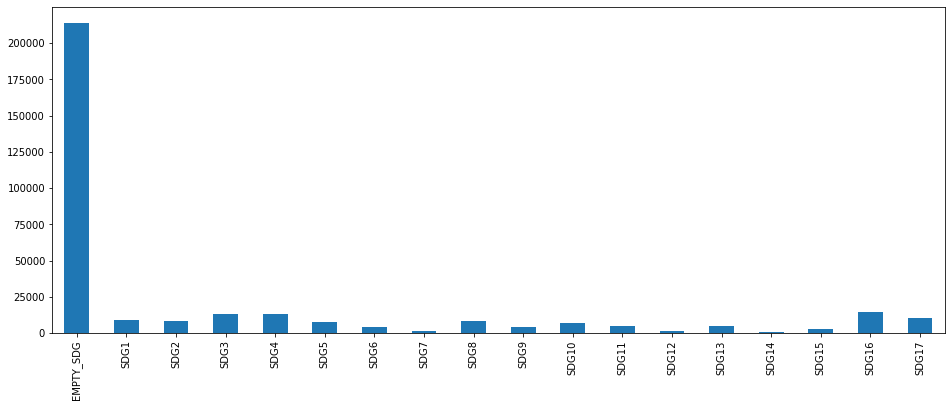

In [23]:
list_sdgs.plot.bar(figsize=(16, 6))

In [24]:
len(df)

287365

## Selecting only SDG Data to Perform Training (Split in Test and Training Sets)

In [25]:
df.CompleteText.nunique()

223011

In [0]:
df_sdg = df[ df['EMPTY_SDG'] == False ]

In [35]:
len(df_sdg), df_sdg.CompleteText.nunique()

(73097, 64116)

In [36]:
df_sdg.drop_duplicates(subset=['CompleteText'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
len(df_sdg)

64116

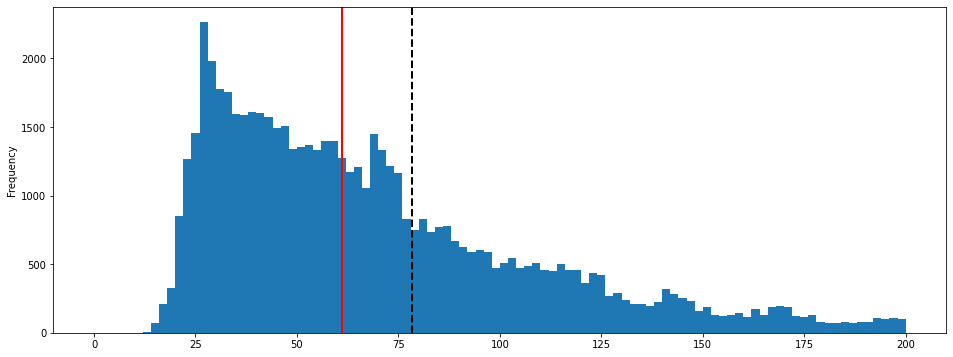

In [38]:
df_sdg['CompleteTextNumber'].plot.hist(bins=100, figsize=(16, 6), range=(0, 200))
plt.axvline(df_sdg['CompleteTextNumber'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(df_sdg['CompleteTextNumber'].median(), color='r', linestyle='solid', linewidth=2)

In [0]:
main_columns = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
               'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17',
                'CompleteText', 'CompleteTextArray']

In [40]:
len(df_sdg)

64116

In [0]:
X = df_sdg[['CompleteText']]
Y = df_sdg[['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
             'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17']]

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(48087, 1) (16029, 1) (48087, 17) (16029, 17)


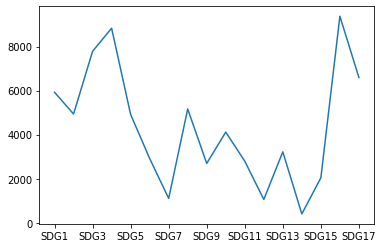

In [44]:
y_train.sum().plot()

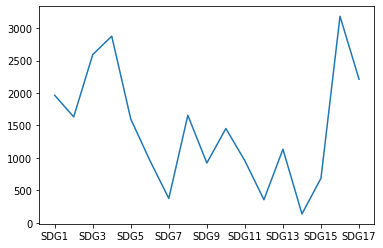

In [45]:
y_test.sum().plot()

In [48]:
len(x_test), len(x_train), len(X)

(16029, 48087, 64116)

#### As shown above the test/train split look statistically similar

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [0]:
#train_file_path = os.path.join( path_to_data, 'train.csv.zip')

In [0]:
#train_file_path

In [0]:
#df = pd.read_csv('train.csv') #jigsaw-toxic-comment-classification-challenge
#df = pd.read_csv(train_file_path) #jigsaw-toxic-comment-classification-challenge
#df.head()

In [52]:
x_train.head()

,CompleteText
87781,Título completo del proyecto: Intervención en ...
102938,USC Canada Seeds of Survival 2015-2020 / USC C...
107680,EMPTY_LONG_DESC IMPROVING THE QUALITY AND OUTR...
211946,The projectÂ¿s end goal is to help high-potent...
97906,Support to Partnerships for Community Developm...


In [53]:
y_train.head()

,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,SDG7,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17
87781,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
102938,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
107680,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
211946,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
97906,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [54]:
#print('Unique comments: ', df.comment_text.nunique() == df.shape[0])
#print('Null values: ', df.isnull().values.any())
# df[df.isna().any(axis=1)]
print('Unique comments: ', x_train.CompleteText.nunique() == x_train.shape[0])
print('Null values: ', x_train.isnull().values.any())


Unique comments:  True
Null values:  False


In [55]:
x_train.CompleteText.nunique(), x_train.shape[0], y_train.shape[0]

(48087, 48087, 48087)

In [56]:
#print('average sentence length: ', df.comment_text.str.split().str.len().mean())
#print('stdev sentence length: ', df.comment_text.str.split().str.len().std())
print('average sentence length: ', x_train.CompleteText.str.split().str.len().mean())
print('stdev sentence length: ', x_train.CompleteText.str.split().str.len().std())

average sentence length:  78.26506124316343
stdev sentence length:  62.23358483173692


In [0]:
df = pd.concat([x_train, y_train], axis=1, sort=False)

In [58]:
df.head()

,CompleteText,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,SDG7,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17
87781,Título completo del proyecto: Intervención en ...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
102938,USC Canada Seeds of Survival 2015-2020 / USC C...,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
107680,EMPTY_LONG_DESC IMPROVING THE QUALITY AND OUTR...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
211946,The projectÂ¿s end goal is to help high-potent...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
97906,Support to Partnerships for Community Developm...,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [59]:
#cols = df.columns
#label_cols = list(cols[2:])
#num_labels = len(label_cols)
#print('Label columns: ', label_cols)
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17']


In [60]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 SDG1     5924
SDG2     4938
SDG3     7786
SDG4     8833
SDG5     4915
SDG6     2917
SDG7     1103
SDG8     5165
SDG9     2693
SDG10    4115
SDG11    2796
SDG12    1057
SDG13    3218
SDG14     400
SDG15    2039
SDG16    9377
SDG17    6595
dtype: int64 

Count of 0 per label: 
 SDG1     42163
SDG2     43149
SDG3     40301
SDG4     39254
SDG5     43172
SDG6     45170
SDG7     46984
SDG8     42922
SDG9     45394
SDG10    43972
SDG11    45291
SDG12    47030
SDG13    44869
SDG14    47687
SDG15    46048
SDG16    38710
SDG17    41492
dtype: int64


In [0]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [62]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,CompleteText,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,SDG7,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17,one_hot_labels
0,Programme: Social Justice. Description: Strate...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,"[False, False, False, False, False, False, Fal..."
1,Syria Crisis - Emergency Health Assistance in ...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"[True, False, False, False, False, False, Fals..."
2,Decentralised Development Cooperation CONTRIBU...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, True, False, False, Fals..."
3,El proyecto pretende reflexionar y actuar con ...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, True, False, Fals..."
4,AUF - Long-term institutional support 2018-20...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, True, False, False, Fals..."


In [0]:
labels = list(df.one_hot_labels.values)
comments = list(df.CompleteText.values)
#comments = list(df.comment_text.values)

In [64]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [48074, 47987, 47978, 47913, 47908, 47614, 46970, 46931, 46863, 46728, 46713, 46669, 46471, 46468, 46384, 46122, 46098, 46039, 45993, 45991, 45988, 45916, 45893, 45712, 45589, 45474, 45409, 45180, 45137, 44922, 44587, 44540, 44348, 44312, 44287, 44222, 44143, 44109, 44028, 43886, 43574, 43556, 43350, 43169, 43151, 43138, 43084, 42876, 42568, 42531, 42478, 42408, 42290, 42285, 42216, 41950, 41771, 41253, 41232, 40905, 40898, 40866, 40794, 40712, 40689, 40534, 40455, 40283, 40243, 40212, 40190, 40128, 39980, 39972, 39952, 39897, 39861, 39640, 39446, 39428, 39398, 38987, 38817, 38766, 38475, 38395, 38126, 38096, 38047, 37920, 37891, 37664, 37341, 37209, 37118, 37054, 36997, 36850, 36509, 36408, 36257, 36169, 36111, 35846, 35656, 35427, 35412, 35189, 35100, 34861, 34699, 34698, 34691, 34471, 34463, 34178, 34112, 34100, 33890, 33847, 33575, 33380, 33189, 33159, 33035, 33016, 32869, 32727, 32658, 32655, 32559, 32545, 32406, 32285, 31840, 31705, 31691

Load the pretrained tokenizer that corresponds to your choice in model. e.g.,

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In order to avoid memory issues with Google Colab, I enforce a max_length of 100 tokens. Note that some sentences may not adequately represent each label because of this.

In [65]:
max_length = 200
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [0]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [0]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [0]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [0]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

Load the appropriate model below, each model already contains a single dense layer for classification on top.



```
BERT:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

XLNet:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

RoBERTa:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
```



In [71]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [0]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

## Train Model

In [74]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.19582591475464922


Epoch:  33%|███▎      | 1/3 [13:29<26:59, 809.71s/it]

F1 Validation Accuracy:  76.43154807840715
Flat Validation Accuracy:  61.01090604026845
Train loss: 0.11188020366498515


Epoch:  67%|██████▋   | 2/3 [26:59<13:29, 809.68s/it]

F1 Validation Accuracy:  81.6685288640596
Flat Validation Accuracy:  68.05788590604027
Train loss: 0.08553614944461706


Epoch: 100%|██████████| 3/3 [40:28<00:00, 809.66s/it]

F1 Validation Accuracy:  84.18601266283386
Flat Validation Accuracy:  71.66526845637584


In [0]:
torch.save(model.state_dict(), 'bert_model_toxic')

## Load and Preprocess Test Data

In [0]:
#test_df = pd.read_csv('test.csv')
#test_labels_df = pd.read_csv('test_labels.csv')
#test_df = test_df.merge(test_labels_df, on='id', how='left')
test_df = pd.concat([x_test, y_test], axis=1, sort=False)

In [86]:
test_df.head()

,CompleteText,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,SDG7,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17
48578,SCAC - P185 - Coopération culturelle - soutien...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
12324,"EMPTY_LONG_DESC OPT,CHILDREN WITH DISABILITIES...",False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
250880,PLANNING. Honduras PLANNING UNICEF UNICEF ODA...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
40219,P185 - Bourses - Maroc - Bourses universitaire...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
103417,Developing Effective and Accountable Democrati...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [88]:
test_label_cols = list(test_df.columns[1:])
print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same

Null values:  False
Same columns between train and test:  True


In [89]:
len(test_df)

16029

In [90]:
#test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,CompleteText,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,SDG7,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17,one_hot_labels
48578,SCAC - P185 - Coopération culturelle - soutien...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, True, False, False, Fals..."
12324,"EMPTY_LONG_DESC OPT,CHILDREN WITH DISABILITIES...",False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,"[False, False, False, True, False, False, Fals..."
250880,PLANNING. Honduras PLANNING UNICEF UNICEF ODA...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"[False, False, False, False, False, False, Fal..."
40219,P185 - Bourses - Maroc - Bourses universitaire...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[False, False, False, True, False, False, Fals..."
103417,Developing Effective and Accountable Democrati...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[False, False, False, False, False, False, Fal..."


In [0]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
#test_comments = list(test_df.comment_text.values)
test_comments = list(test_df.CompleteText.values)

In [0]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [0]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [0]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [95]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.830363430717685
Test Flat Accuracy:  0.7111485432653316 

              precision    recall  f1-score   support

        SDG1       0.85      0.69      0.76      1965
        SDG2       0.82      0.81      0.82      1632
        SDG3       0.90      0.88      0.89      2591
        SDG4       0.93      0.83      0.88      2875
        SDG5       0.89      0.62      0.73      1600
        SDG6       0.86      0.86      0.86       964
        SDG7       0.84      0.85      0.84       376
        SDG8       0.88      0.78      0.83      1656
        SDG9       0.84      0.73      0.78       922
       SDG10       0.90      0.70      0.79      1453
       SDG11       0.81      0.78      0.80       956
       SDG12       0.79      0.37      0.50       357
       SDG13       0.83      0.77      0.80      1134
       SDG14       0.88      0.62      0.73       138
       SDG15       0.79      0.76      0.78       688
       SDG16       0.89      0.85      0.87      3182
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Dataframe

In [104]:
idx2label = dict(zip(range(17),label_cols))
print(idx2label)

{0: 'SDG1', 1: 'SDG2', 2: 'SDG3', 3: 'SDG4', 4: 'SDG5', 5: 'SDG6', 6: 'SDG7', 7: 'SDG8', 8: 'SDG9', 9: 'SDG10', 10: 'SDG11', 11: 'SDG12', 12: 'SDG13', 13: 'SDG14', 14: 'SDG15', 15: 'SDG16', 16: 'SDG17'}


In [0]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [0]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [0]:
# Decoding input ids to comment text
comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [108]:
# Converting lists to df
comparisons_df = pd.DataFrame({'comment_text': comment_texts, 'true_labels': true_label_texts, 'pred_labels':pred_label_texts})
comparisons_df.to_csv('comparisons.csv')
comparisons_df.head()

,comment_text,true_labels,pred_labels
0,scac - p185 - cooperation culturelle - soutien...,[SDG4],[SDG4]
1,"empty _ long _ desc opt , children with disabi...","[SDG4, SDG10]","[SDG4, SDG10]"
2,planning . honduras planning unicef unicef oda...,[SDG17],[SDG17]
3,p185 - bourses - maroc - bourses universitaire...,[SDG4],[SDG4]
4,developing effective and accountable democrati...,[SDG16],[SDG16]


## Bonus - Optimizing threshold value for micro F1 score

Doing this may result in a trade offs between precision, flat accuracy and micro F1 accuracy. You may tune the threshold however you want.

In [109]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. First with 'macro_thresholds' on the order of e^-1 then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, flat_acc_results = [], []
for th in macro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Accuracy: ', f1_results[best_f1_idx])
print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
pickle.dump(clf_report_optimized, open('classification_report_optimized.txt','wb'))
print(clf_report_optimized)

Best Threshold:  0.52
Test F1 Accuracy:  0.830717031374149
Test Flat Accuracy:  0.71102376941793 

              precision    recall  f1-score   support

        SDG1       0.86      0.68      0.76      1965
        SDG2       0.83      0.81      0.82      1632
        SDG3       0.91      0.88      0.89      2591
        SDG4       0.94      0.83      0.88      2875
        SDG5       0.90      0.62      0.73      1600
        SDG6       0.87      0.85      0.86       964
        SDG7       0.84      0.84      0.84       376
        SDG8       0.89      0.78      0.83      1656
        SDG9       0.85      0.73      0.78       922
       SDG10       0.91      0.70      0.79      1453
       SDG11       0.82      0.77      0.80       956
       SDG12       0.81      0.36      0.50       357
       SDG13       0.85      0.77      0.81      1134
       SDG14       0.88      0.62      0.73       138
       SDG15       0.81      0.76      0.78       688
       SDG16       0.89      0.84   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
